# Dipolo que se prende en el origen
Este notebook muestra la dinámica de un dipolo puntual que se prende en el origen a t=0. La solución al dipolo que se prende corresponde a la solución exacta obtenida con la función de Green retardada. Recuerden que cada celda a continuación debe ejecutarse en orden, apretando SHIFT+ENTER:

In [1]:
# El código en esta celda asegura que SymPy funcione correctamente en Google colab o en sus computadoras
import os
if "COLAB_GPU" in os.environ:
  from sympy import *
  def custom_latex_printer(expr, **options):
      from IPython.display import Math, HTML
      from google.colab.output._publish import javascript
      url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-AMS_CHTML"
      javascript(content="""window.MathJax = { tex2jax: { inlineMath: [ ['$','$'] ], processEscapes: true } };""")
      javascript(url=url)
      return latex(expr, **options)
  init_printing(use_latex="mathjax", latex_printer=custom_latex_printer)
else:
  from sympy import *
  init_printing()

## Solución analítica
Comenzamos usando SymPy para calcular las expresiones del campo eléctrico y magnético en coordenadas cartesianas. Para ilustrar numéricamente los campos de radiación en la superficie que se propaga con velocidad c, en lugar de usar funciones de Heaviside y deltas de Dirac, usamos sucesiones de funciones que tienden a estas distribuciones. Más tarde elegiremos la pendiente de estas funciones muy grandes, para que aproximen a la función escalón y a sus derivadas.

In [2]:
# Importamos el módulo para cálculo vectorial
from sympy.vector import *

# Definimos variables simbólicas
p0        = symbols("p0",    real=True)
theta,phi = symbols("theta phi", real=True)
x,y,z     = symbols("x y z", real=True)
c,t,s     = symbols("c t z", real=True)
n         = symbols("n",     integer=True)

In [3]:
# Definimos funciones que tienden a la distribución de Heaviside, Dirac, y su derivada; "n" controla la pendiente:
heavi  = (tanh(n*s)+1)/2
delta  = diff(heavi, s)
deltap = diff(delta, s)

In [4]:
# Definimos un sistema de coordenadas cartesiano; (n.i,n.j,n.k) serán los 3 versores cartesianos
n = CoordSys3D('n')

# Definimos un dipolo con amplitud p0 que apunta en la dirección z
p = p0*n.k

# Construimos el vector r, y su módulo; "dot" calcula el producto escalar 
r    = x*n.i + y*n.j + z*n.k
rlen = sqrt(dot(r,r))

# Definimos los versores en esféricas (r,theta,phi)
rvers = sin(theta)*cos(phi)*n.i + sin(theta)*sin(phi)*n.j + cos(theta)*n.k
tvers = cos(theta)*cos(phi)*n.i + cos(theta)*sin(phi)*n.j - sin(theta)*n.k
pvers =           -sin(phi)*n.i +            cos(phi)*n.j

# Definimos el ángulo theta en término de las coordenadas cartesianas usando la inversa de la tangente
theta = atan2(sqrt(x**2+y**2),z)

# Definimos el campo eléctrico y magnético
E = ((3*dot(p,r)*r-dot(r,r)*p)/rlen**5)*heavi.subs(s,t-rlen/c) + p0*z/(c*rlen**3)*rvers*delta.subs(s,t-rlen/c) + (1/c)*((2*dot(p,r)*r-dot(r,r)*p)/rlen**4)*delta.subs(s,t-rlen/c) + p0/(c**2*rlen)*sin(theta)*deltap.subs(s,t-rlen/c)
B = p0/(c*rlen**2)*pvers*delta.subs(s,t-rlen/c) + p0/(c**2*rlen)*pvers*deltap.subs(s,t-rlen/c)

In [5]:
# Calculamos la componente x del campo eléctrico en el plano y=0 (phi=0); "dot" contra el versor nos da la proyección
E_x = simplify(dot(E,n.i).subs(phi,0).subs(y,0))
E_x

KeyboardInterrupt: 

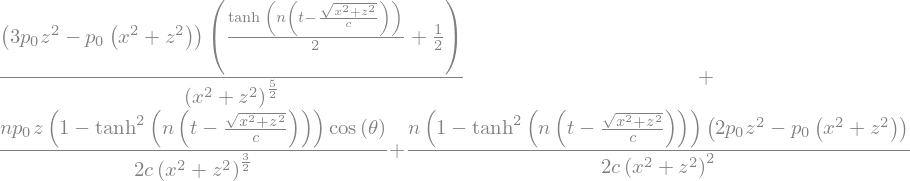

In [59]:
# Calculamos la componente z del campo eléctricoen el plano y=0 (phi=0):
E_z = dot(E,n.k).subs(phi,0).subs(y,0)
E_z

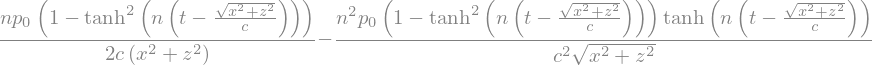

In [60]:
# Calculamos la componente y del campo magnético el plano y=0 (phi=0):
B_y = dot(B,n.j).subs(phi,0).subs(y,0)
B_y

## Visualización de los campos
Ahora usamos Numpy y Matplotlib para graficar el resultado en el plano (x,z). Construimos explícitamente funciones que nos devuelvan los valores numéricos de las expresiones que calculamos con SymPy, ya que la función "lambdify" de SymPy no funciona muy bien con cantidades vectoriales o que se deriven de magnitudes vectoriales.

In [6]:
# Importamos NumPy y Matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [7]:
# Definimos funciones para las componentes de los campos usando lo que calculamos con SymPy
def ex(x,z,t):
    theta = np.arctan2(x,z)
    return -p0*z*(-3*c*x*(x**2 + z**2)**(7/2)*(np.tanh(n*(c*t - np.sqrt(x**2 + z**2))/c) + 1) + 2*n*x*(x**2 + z**2)**4*(np.tanh(n*(c*t - np.sqrt(x**2 + z**2))/c)**2 - 1) + n*(x**2 + z**2)**(9/2)*(np.tanh(n*(c*t - np.sqrt(x**2 + z**2))/c)**2 - 1)*np.sin(theta))/(2*c*(x**2 + z**2)**6)

def ez(x,z,t):
    theta = np.arctan2(x,z)
    return (3*p0*z**2 - p0*(x**2 + z**2))*(np.tanh(n*(t - np.sqrt(x**2 + z**2)/c))/2 + 1/2)/(x**2 + z**2)**(5/2) + n*p0*z*(1 - np.tanh(n*(t - np.sqrt(x**2 + z**2)/c))**2)*np.cos(theta)/(2*c*(x**2 + z**2)**(3/2)) + n*(1 - np.tanh(n*(t - np.sqrt(x**2 + z**2)/c))**2)*(2*p0*z**2 - p0*(x**2 + z**2))/(2*c*(x**2 + z**2)**2)

def by(x,z,t):
    return n*p0*(1 - np.tanh(n*(t - np.sqrt(x**2 + z**2)/c))**2)/(2*c*(x**2 + z**2)) - n**2*p0*(1 - np.tanh(n*(t - np.sqrt(x**2 + z**2)/c))**2)*np.tanh(n*(t - np.sqrt(x**2 + z**2)/c))/(c**2*np.sqrt(x**2 + z**2))

In [8]:
# Definimos valores para los parámetros del sistema
p0 = 1   # Intensidad del dipolo
c  = 1   # velocidad de la luz
n  = 100 # controla el ancho del escalón en la aproximación a la función de Heaviside (debe ser grande)

KeyboardInterrupt: 

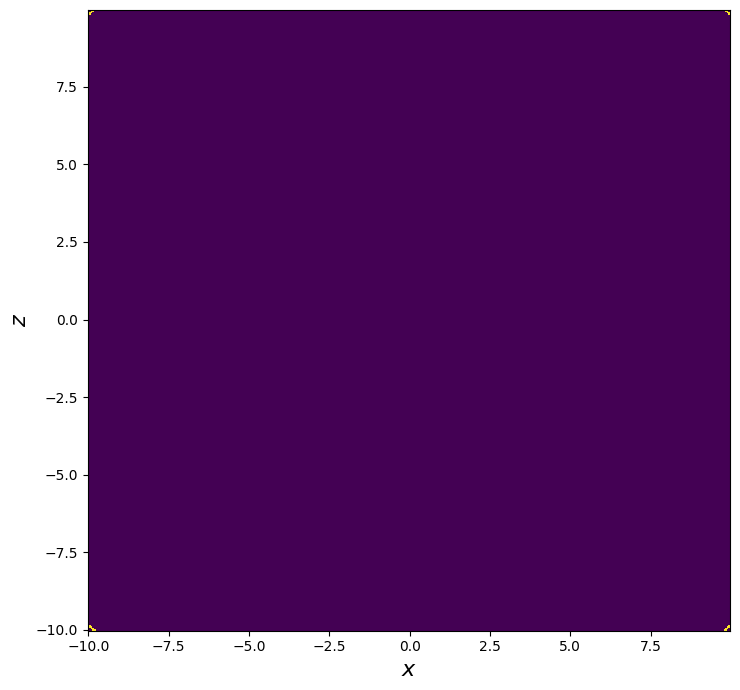

In [9]:
# Graficamos la intensidad del campo magnético en la dirección y (normal al plano x,z)
xv = np.arange(-10,10,.05)       # generamos un vector para x entre -10 y 10 con paso de 0.5
zv = np.arange(-10,10,.05)+1e-15 # generamos un vector para z entre -10 y 10 y lo desplazamos para evitar la singularidad en el origen
x, z = np.meshgrid(xv, zv)       # generamos una malla 2D con todos los valores de x y z en cada punto

# Graficamos el potencial electrostático e
plt.rcParams["figure.figsize"] = (7.5,7)
fig = plt.figure()
for t in np.arange(0,15,.5):
    plt.pcolormesh(x,z,by(x,z,t),vmin=0,vmax=1)
    plt.xlabel(r'$x$',fontsize=16)
    plt.ylabel(r'$z$',fontsize=16)
    plt.tight_layout()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.pause(0.01)
plt.show()

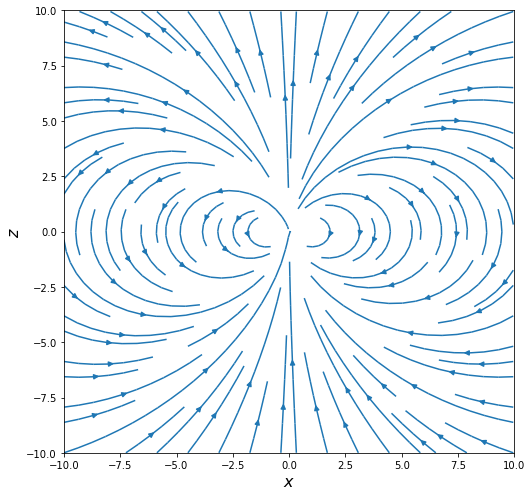

In [85]:
# Graficamos el campo eléctrico en el plano (x,z)
fig = plt.figure()
for t in np.arange(0,15,.5):
    plt.figure(figsize=(7.5,7))
    plt.streamplot(x,z,ex(x,z,t),ez(x,z,t))
    plt.xlabel(r'$x$',fontsize=16)
    plt.ylabel(r'$z$',fontsize=16)
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.tight_layout()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.pause(0.01)
plt.show()